In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import random
from types import SimpleNamespace
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import matplotlib.pyplot as plt

In [3]:
data_path="LEAD_DATASET/train.csv"

data_csv=pd.read_csv(data_path,low_memory=False)

In [4]:
data_csv.head()

,building_id,timestamp,meter_reading,anomaly
0,1,2016-01-01 00:00:00,NaN,0
1,32,2016-01-01 00:00:00,NaN,0
2,41,2016-01-01 00:00:00,NaN,0
3,55,2016-01-01 00:00:00,NaN,0
4,69,2016-01-01 00:00:00,NaN,0


In [5]:
data_csv.tail()

,building_id,timestamp,meter_reading,anomaly
1749489,1316,2016-12-31 23:00:00,38.844,0
1749490,1318,2016-12-31 23:00:00,202.893,0
1749491,1319,2016-12-31 23:00:00,NaN,0
1749492,1323,2016-12-31 23:00:00,172.000,0
1749493,1353,2016-12-31 23:00:00,2.400,0


In [6]:
b_id=1304

In [7]:
sample_df=data_csv[data_csv['building_id'] == b_id].copy()

In [8]:
sample_df.reset_index(drop=True,inplace=True)

In [9]:
sample_df

,building_id,timestamp,meter_reading,anomaly
0,1304,2016-01-01 00:00:00,269.984,0
1,1304,2016-01-01 01:00:00,270.834,0
2,1304,2016-01-01 02:00:00,282.987,0
3,1304,2016-01-01 03:00:00,287.950,0
4,1304,2016-01-01 04:00:00,305.913,0
...,...,...,...,...
8779,1304,2016-12-31 19:00:00,319.548,0
8780,1304,2016-12-31 20:00:00,310.931,0
8781,1304,2016-12-31 21:00:00,293.985,0
8782,1304,2016-12-31 22:00:00,331.945,0


# Paper Implementation

In [37]:
def _generate_anomaly_indices_and_lengths(rng, series_len, count, length_params=None, existing_indices=None):
    if count == 0:
        return np.array([], dtype=int), np.array([], dtype=int)

    if existing_indices is None:
        existing_indices = set()

    lengths = []
    if length_params:
        # if length_params.get('distribution') == 'uniform':
        #     min_len = length_params['min']
        #     max_len = length_params['max']
        #     if min_len > max_len:
        #          warnings.warn(f"min_len ({min_len}) > max_len ({max_len}). Setting max_len = min_len.")
        #          max_len = min_len
        #     if min_len <= 0:
        #          warnings.warn(f"min_len ({min_len}) is <= 0. Setting min_len = 1.")
        #          min_len = 1
        #          if max_len < 1: max_len = 1 # Ensure max_len is also at least 1
        #     lengths = rng.integers(min_len, max_len + 1, size=count)
        # else:
        #     warnings.warn(f"Unsupported length distribution {length_params.get('distribution')}. Assuming length 1.")
        #     lengths = np.ones(count, dtype=int)

        min_samples=int(series_len*length_params['min']/100)
        max_samples=int(series_len*length_params['max']/100)
        total_samples=np.random.choice(range(min_samples,max_samples))
        print(total_samples)

        seq_min=2
        seq_max=5
        all_seq_lengths=[]
        while(total_samples>0):
            choice=np.random.choice(range(seq_min,seq_max+1))
            all_seq_lengths.append(choice)
            total_samples-=choice
        count=len(all_seq_lengths)
        
    else:
        lengths = np.ones(count, dtype=int)
        all_seq_lengths = lengths 

    indices = []
    max_attempts = count * 10 # Try a reasonable number of times to find non-overlapping spots
    attempts = 0

    possible_start_indices = np.arange(series_len) # All possible indices initially
    #Change it to days instead use random indices - day of the year [ don't use initial zero values]
    
    while len(indices) < count and attempts < max_attempts:
        attempts += 1
        potential_length = all_seq_lengths[len(indices)] # Length for the current anomaly we try to place
        max_valid_start = series_len - potential_length

        if max_valid_start < 0: 
             warnings.warn(f"Anomaly length ({potential_length}) > series length ({series_len}). Cannot place.")
             continue 

        valid_start_indices = possible_start_indices[possible_start_indices <= max_valid_start]

        if len(valid_start_indices) == 0:
             break 

        potential_start = rng.choice(valid_start_indices)
        potential_end = potential_start + potential_length

        is_overlapping = False
        for idx in range(potential_start, potential_end):
            if idx in existing_indices:
                is_overlapping = True
                break

        if not is_overlapping:
            indices.append(potential_start)
            for idx in range(potential_start, potential_end):
                 existing_indices.add(idx)

    if len(indices) < count:
        warnings.warn(f"Could only place {len(indices)} out of {count} requested non-overlapping anomalies.")
        all_seq_lengths = all_seq_lengths[:len(indices)]

    return np.array(indices, dtype=int), np.array(all_seq_lengths, dtype=int)


In [38]:
def _apply_labels(labels, indices, lengths, label_value):
    """Applies labels to the specified ranges."""
    for i, start_idx in enumerate(indices):
        end_idx = start_idx + lengths[i]
        actual_end = min(end_idx, len(labels))
        labels[start_idx:actual_end] = label_value
    return labels

In [39]:
def _generate_power_anomaly_type3(p_current, labels_current, p_original, count, label, seed, anomaly_params, rng, existing_indices):
    """Applies Power Anomaly Type 3 based on Formulas (7) and (8)."""
    if count == 0:
        return p_current, labels_current, existing_indices, np.array([]), np.array([])

    target = p_current.copy()
    labels_next = labels_current.copy()
    local_rng = np.random.default_rng(seed)

    # Length is always 1 for Type 3 power anomaly spike
    indices, lengths = _generate_anomaly_indices_and_lengths(
        local_rng, len(target), count, length_params=None, existing_indices=existing_indices
    )

    if len(indices) == 0:
        return p_current, labels_current, existing_indices, np.array([]), np.array([])

    is_extreme = anomaly_params.get('is_extreme', False)
    k = anomaly_params.get('k', 0)  # Needed for extreme case
    range_r = anomaly_params.get('range_r', (0.61, 1.62))  # Default from paper Table 3

    for idx, length in zip(indices, lengths):
        if length > 1:
            raise Exception("Type 3 power anomalies can't be longer than 1.")
        else:
            if is_extreme:
                energy_consumed = target[:idx].sum()
                target[idx] = -1 * energy_consumed - k
            else:
                r = np.random.uniform(*range_r)
                target[idx] = -1 * r * target[idx - 1]

    labels_next = _apply_labels(labels_next, indices, lengths, label)

    return target, labels_next, existing_indices, indices, lengths

In [40]:
def create_power_anomalies_from_paper(p, e, hparams,apply_rules=[1,2,3,4]):
    """
    Generates power anomalies based on formulas in Turowski et al. (2022).

    Args:
        p (np.ndarray): The input power time series.
        e (np.ndarray): The corresponding input energy time series (needed for k).
        hparams (SimpleNamespace or similar): Object containing hyperparameters.
                                             See original code/paper for attributes.

    Returns:
        tuple: (p_original, labels, p_anomalous)
    """
    p_original = np.asarray(p).copy()
    p_modified = p_original.copy()
    labels = np.zeros_like(p_modified, dtype=int)
    n = len(p_modified)
    master_rng = np.random.default_rng(hparams.seed)
    existing_indices = set() # Track indices covered by any anomaly





    # Type 2
    if 3 in apply_rules:
        p_modified, labels, existing_indices, indices, lengths = _generate_power_anomaly_type3(
    p_modified, labels, p_original, count=hparams.num_anomalies, label=3, seed=hparams.seed + 2,
    anomaly_params={'softstart': getattr(hparams, 'type2_softstart', False)},
    rng=master_rng, existing_indices=existing_indices
)
        print(f"Applied Power Type 3. Anomalous indices count: {len(existing_indices)}")

    return p_original, labels, p_modified,indices,lengths


## Data Imputer

In [41]:
from sklearn.impute import SimpleImputer

In [42]:
def data_preprocess(sample_df):

    sample_df.loc[sample_df.anomaly==1,'meter_reading']=np.nan
    original_anomalies=np.zeros_like(sample_df['anomaly'].values)
    sample_df['meter_reading'] = sample_df['meter_reading'].ffill()
    imp_vals=sample_df['meter_reading'].values
    return imp_vals,original_anomalies

In [43]:
def do_for_building(df,bid):
    sample_df=df[df['building_id']==bid].copy()
    imp_vals,labels_p=data_preprocess(sample_df)
    power_hparams = SimpleNamespace(
    seed=42,
    type2=100, min_perc=2, max_perc=5, type2_softstart=True,
    )
    # Get total number of samples
    total_samples=len(imp_vals)
    # Find min and max number of anomalies
    min_anomalies = int(total_samples * power_hparams.min_perc / 100)
    max_anomalies = int(total_samples * power_hparams.max_perc / 100)
    # Generate random number of anomalies
    rng = np.random.default_rng()
    num_anomalies = rng.integers(min_anomalies, max_anomalies + 1)
    power_hparams.num_anomalies = num_anomalies
    original_p, labels_p, anomalous_p,indices,lengths= create_power_anomalies_from_paper(imp_vals, None, power_hparams,apply_rules=[3])
    all_ticks = sample_df['timestamp'].values
    mod_df=pd.DataFrame()
    mod_df['timestamp']=all_ticks
    mod_df['original']=original_p
    mod_df['modified']=anomalous_p
    mod_df['labels']=labels_p
    orig_mean,mod_mean,nums,min_len,max_len=mod_df['original'].mean(),mod_df['modified'].mean(),len(indices),min(lengths),max(lengths)
    all_anoms=mod_df[mod_df['labels']==3].sum().values[-1]
    return orig_mean,mod_mean,nums,min_len,max_len,all_anoms,mod_df
        

In [46]:
bids=[]
orig_means=[]
mod_means=[]
all_nums=[]
all_mins=[]
all_maxs=[]
total_anomalies=[]
for bid in data_csv['building_id'].unique():
    or_mean,m_mean,nu,mi,ma,al,mod_df=do_for_building(data_csv,bid)
    mod_df.to_csv(f"OUTPUT/MODIFIED/{bid}_modified.csv",index=False)
    bids.append(bid)
    orig_means.append(or_mean)
    mod_means.append(m_mean)
    all_nums.append(nu)
    all_mins.append(mi)
    all_maxs.append(ma)
    total_anomalies.append(al)
    

Applied Power Type 3. Anomalous indices count: 343
Applied Power Type 3. Anomalous indices count: 362
Applied Power Type 3. Anomalous indices count: 408
Applied Power Type 3. Anomalous indices count: 296
Applied Power Type 3. Anomalous indices count: 433
Applied Power Type 3. Anomalous indices count: 232
Applied Power Type 3. Anomalous indices count: 403
Applied Power Type 3. Anomalous indices count: 410
Applied Power Type 3. Anomalous indices count: 265
Applied Power Type 3. Anomalous indices count: 196
Applied Power Type 3. Anomalous indices count: 291
Applied Power Type 3. Anomalous indices count: 188
Applied Power Type 3. Anomalous indices count: 194
Applied Power Type 3. Anomalous indices count: 436
Applied Power Type 3. Anomalous indices count: 404
Applied Power Type 3. Anomalous indices count: 200
Applied Power Type 3. Anomalous indices count: 203
Applied Power Type 3. Anomalous indices count: 243
Applied Power Type 3. Anomalous indices count: 177
Applied Power Type 3. Anomalous

In [31]:
print(len(bids))

200


In [47]:
stats_df=pd.DataFrame()
stats_df['building_id']=bids
stats_df['orginal_mean']=orig_means
stats_df['modified_mean']=mod_means
stats_df['anomalous_subsequeces']=all_nums
stats_df['minimum_lengths']=all_mins
stats_df['maximum_lengths']=all_maxs
stats_df['total_anomalies']=total_anomalies

In [48]:
stats_df

,building_id,orginal_mean,modified_mean,anomalous_subsequeces,minimum_lengths,maximum_lengths,total_anomalies
0,1,35.348965,32.505515,343,1,1,1029
1,32,97.808259,89.052346,362,1,1,1086
2,41,61.177530,55.119578,408,1,1,1224
3,55,33.693479,31.286499,296,1,1,888
4,69,29.393432,26.299483,433,1,1,1299
...,...,...,...,...,...,...,...
195,1316,53.316940,49.312520,314,1,1,942
196,1318,161.258038,147.637373,346,1,1,1038
197,1319,136.074148,126.542217,291,1,1,873
198,1323,185.671790,174.326767,248,1,1,744


In [34]:
stats_df.to_csv(f"OUTPUT/STATS/type_3_anomalies.csv",index=False)

In [49]:
imp_vals,labels_p=data_preprocess(sample_df)

## Apply to actual readings

In [63]:
power_hparams = SimpleNamespace(
    seed=42,
    type2=100, min_perc=2, max_perc=5, type2_softstart=True,
    type3=2, type3_extreme=False, type3_r_min=0.6, type3_r_max=1.6, # Based on paper Table 3/4 'slight'
    type4=4, type4_r_min=1, type4_r_max=2.0, # Based on paper Table 3/4 'slight'
)

In [ ]:
print("--- Generating Power Anomalies ---")
original_p, labels_p, anomalous_p, indices,lengths= create_power_anomalies_from_paper(imp_vals, None, power_hparams,apply_rules=[3])

--- Generating Power Anomalies ---


UnboundLocalError: local variable 'indices' referenced before assignment

In [21]:
np.unique(labels_p,return_counts=True)

(array([0, 2]), array([8359,  425]))

In [22]:
print(f"\nPower Data Shape: {original_p.shape}")
print(f"Power Labels Shape: {labels_p.shape}")
print(f"Anomalous Power Shape: {anomalous_p.shape}")
print(f"Number of Power Anomalies (by label): {np.unique(labels_p, return_counts=True)}")


Power Data Shape: (8784,)
Power Labels Shape: (8784,)
Anomalous Power Shape: (8784,)
Number of Power Anomalies (by label): (array([0, 2]), array([8359,  425]))


In [23]:
np.max(original_p),np.min(original_p)

(np.float64(647.782), np.float64(173.982))

In [24]:
np.max(anomalous_p),np.min(anomalous_p)

(np.float64(1879.3018772391206), np.float64(0.0))

In [25]:
all_ticks = sample_df['timestamp'].values

In [26]:
# value_dict={'timestamp': all_ticks.flatten(),
#             'original': original_p.flatten(),
#             'modified': anomalous_p.flatten(),
#            'labels': labels_p.flatten()}
mod_df=pd.DataFrame()
mod_df['timestamp']=all_ticks
mod_df['original']=original_p
mod_df['modified']=anomalous_p
mod_df['labels']=labels_p
mod_df

,timestamp,original,modified,labels
0,2016-01-01 00:00:00,269.984,269.984,0
1,2016-01-01 01:00:00,270.834,270.834,0
2,2016-01-01 02:00:00,282.987,282.987,0
3,2016-01-01 03:00:00,287.950,287.950,0
4,2016-01-01 04:00:00,305.913,305.913,0
...,...,...,...,...
8779,2016-12-31 19:00:00,319.548,319.548,0
8780,2016-12-31 20:00:00,310.931,310.931,0
8781,2016-12-31 21:00:00,293.985,293.985,0
8782,2016-12-31 22:00:00,331.945,331.945,0


In [27]:
mod_df[mod_df['labels']==2]

,timestamp,original,modified,labels
155,2016-01-07 11:00:00,323.941,45.210418,2
156,2016-01-07 12:00:00,407.928,686.658582,2
170,2016-01-08 02:00:00,365.857,40.638180,2
171,2016-01-08 03:00:00,339.344,0.000000,2
172,2016-01-08 04:00:00,330.046,0.000000,2
...,...,...,...,...
8706,2016-12-28 18:00:00,359.764,1006.840083,2
8728,2016-12-29 16:00:00,360.043,149.014414,2
8729,2016-12-29 17:00:00,366.179,0.000000,2
8730,2016-12-29 18:00:00,384.016,0.000000,2


In [28]:
print(mod_df['original'].mean(),mod_df['modified'].mean(),len(indices),min(lengths),max(lengths))

311.93116734972676 311.93116734972676 119 2 5


In [29]:
max_e=int(np.max(anomalous_p))

In [30]:
all_ticks = sample_df['timestamp'].values

In [31]:
SEQ_LEN=100
START_INDEX=(3*30+3)*24+30
print(START_INDEX)

2262


In [32]:
selected_all_ticks=all_ticks[START_INDEX:START_INDEX+SEQ_LEN]
selected_original_p=original_p[START_INDEX:START_INDEX+SEQ_LEN]
selected_anomalous_p=anomalous_p[START_INDEX:START_INDEX+SEQ_LEN]
selected_labels_p=labels_p[START_INDEX:START_INDEX+SEQ_LEN]

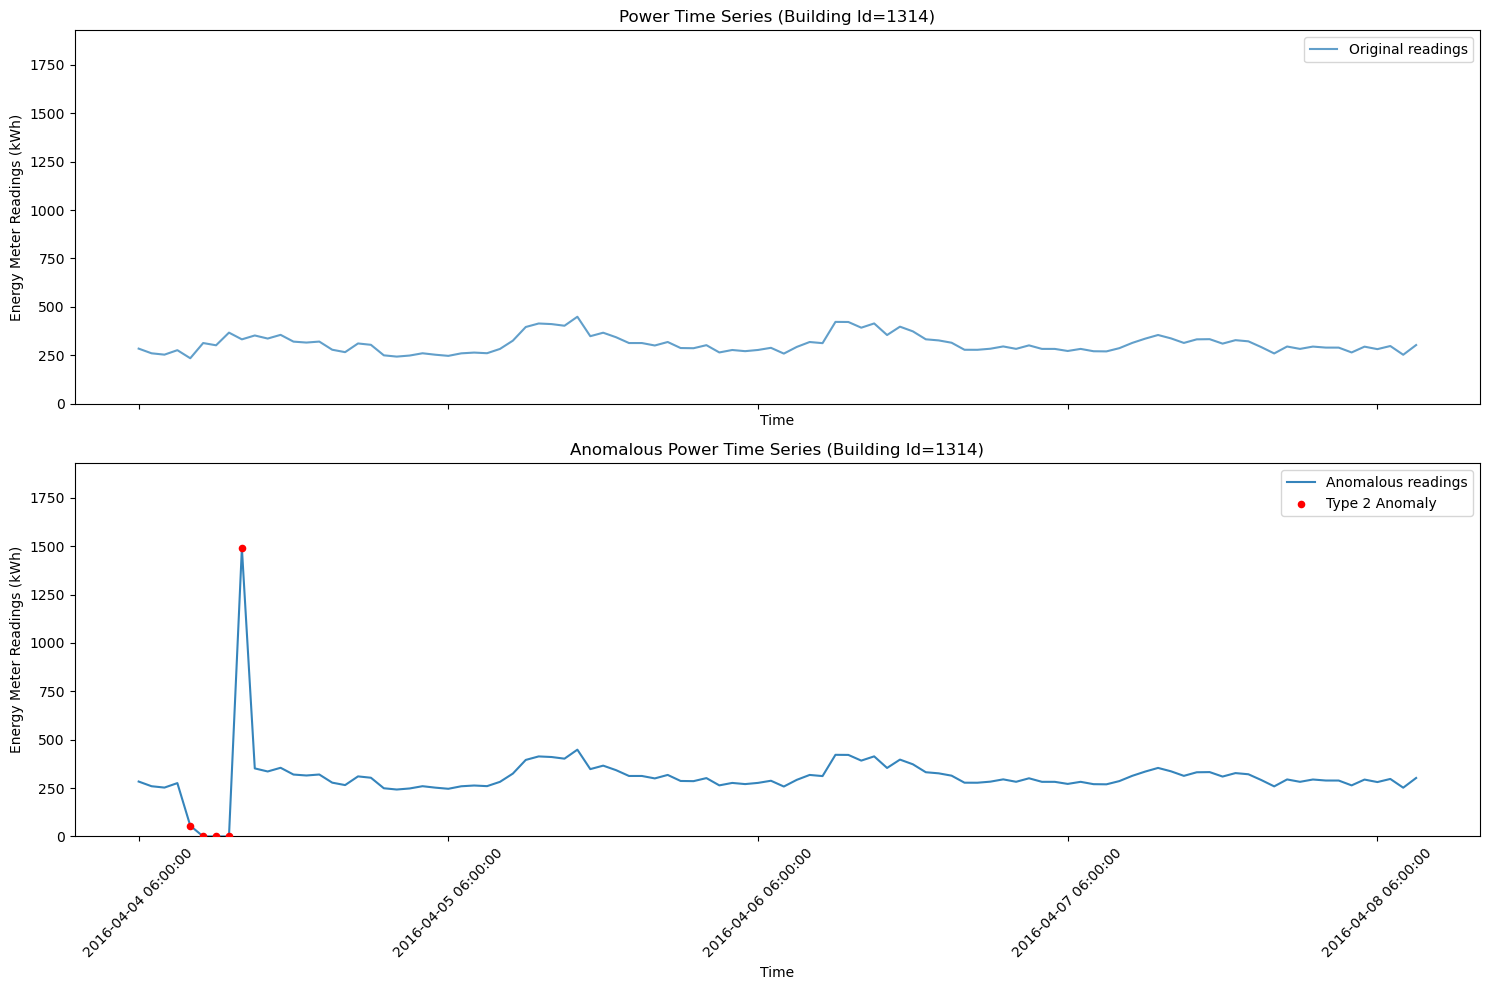

In [33]:

fig, axs = plt.subplots(2,1,figsize=(15, 10), sharex=True)

axs[0].plot(selected_all_ticks, selected_original_p, label='Original readings', alpha=0.7, zorder=1)
axs[1].plot(selected_all_ticks, selected_anomalous_p, label='Anomalous readings', alpha=0.9, zorder=2)
# Highlight anomalies
_type=2
selected_anomaly_indices_p = np.where(selected_labels_p == _type)[0]
if len(selected_anomaly_indices_p) > 0:
     axs[1].scatter(selected_all_ticks[selected_anomaly_indices_p], selected_anomalous_p[selected_anomaly_indices_p], color='red', s=20, label=f'Type {_type} Anomaly', zorder=3)
axs[0].set_title('Power Time Series (Building Id=1314)')
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Energy Meter Readings (kWh)")
axs[0].grid(False)
axs[1].set_title('Anomalous Power Time Series (Building Id=1314)')
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Energy Meter Readings (kWh)")
axs[1].grid(False)
new_ticks=selected_all_ticks[::24]
axs[0].set_ylim(0,max_e+50)
axs[1].set_ylim(0,max_e+50)
# axs.set_xticks(new_ticks,rotate=45)
plt.xticks(new_ticks, rotation=45)
axs[0].legend()
axs[1].legend()
plt.tight_layout()
fig.savefig('type_3_anomaly.png')

In [34]:
SEQ_LEN=100
START_INDEX=(3*30+3)*24+30+1000
print(START_INDEX)

3262


In [35]:
selected_all_ticks=all_ticks[START_INDEX:START_INDEX+SEQ_LEN]
selected_original_p=original_p[START_INDEX:START_INDEX+SEQ_LEN]
selected_anomalous_p=anomalous_p[START_INDEX:START_INDEX+SEQ_LEN]
selected_labels_p=labels_p[START_INDEX:START_INDEX+SEQ_LEN]

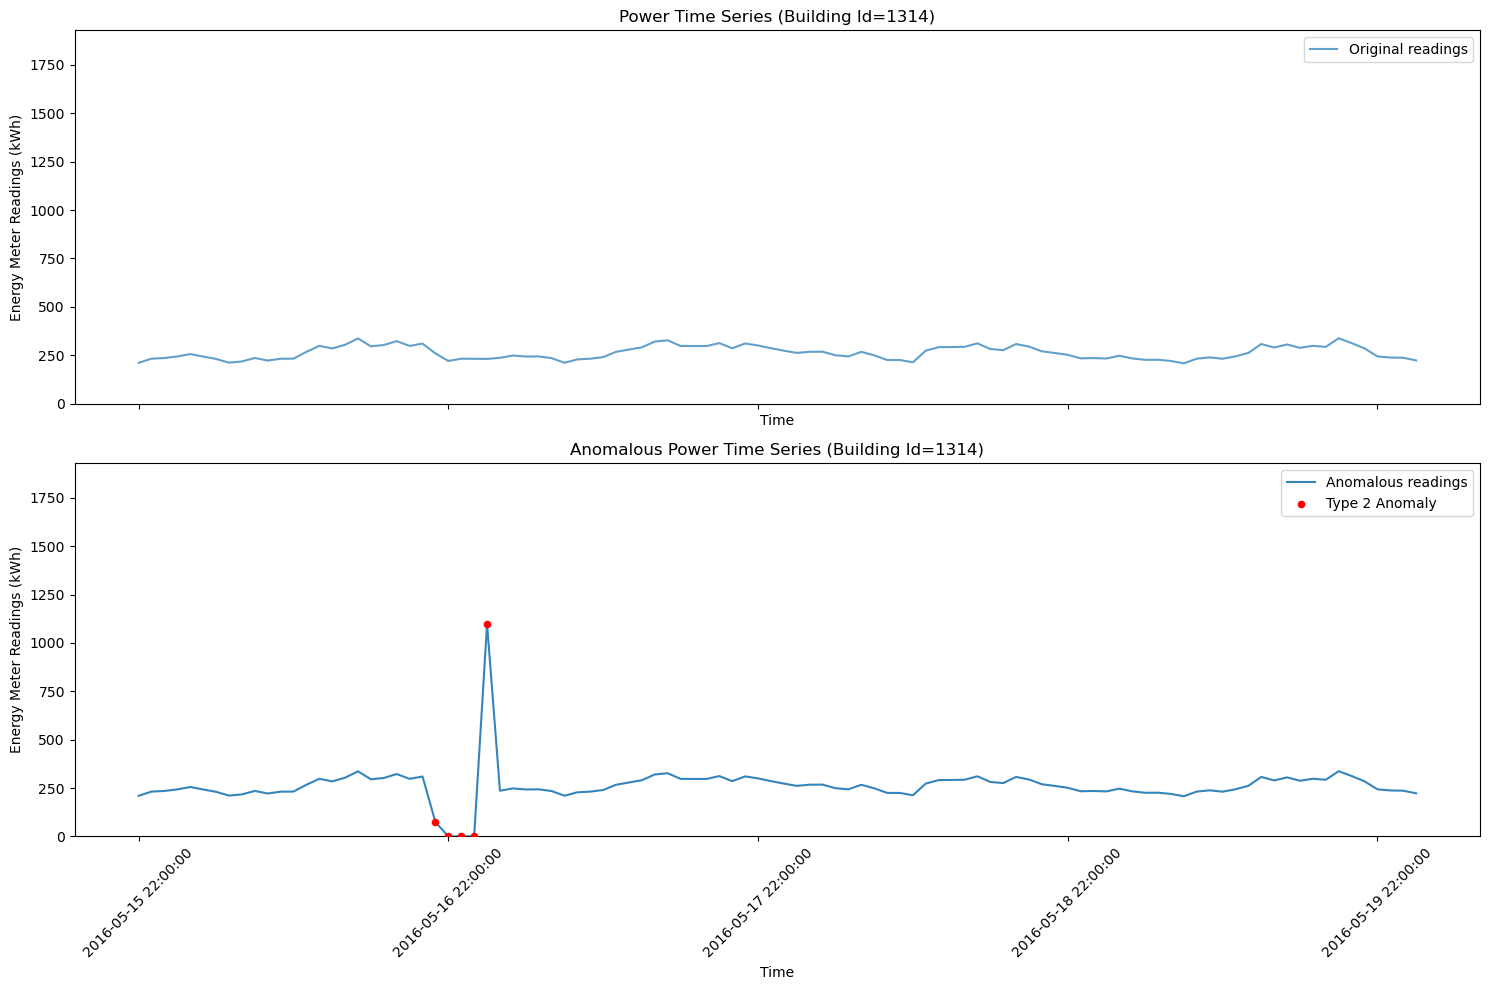

In [36]:

fig, axs = plt.subplots(2,1,figsize=(15, 10), sharex=True)

axs[0].plot(selected_all_ticks, selected_original_p, label='Original readings', alpha=0.7, zorder=1)
axs[1].plot(selected_all_ticks, selected_anomalous_p, label='Anomalous readings', alpha=0.9, zorder=2)
# Highlight anomalies
_type=2
selected_anomaly_indices_p = np.where(selected_labels_p == _type)[0]
if len(selected_anomaly_indices_p) > 0:
     axs[1].scatter(selected_all_ticks[selected_anomaly_indices_p], selected_anomalous_p[selected_anomaly_indices_p], color='red', s=20, label=f'Type {_type} Anomaly', zorder=3)
axs[0].set_title('Power Time Series (Building Id=1314)')
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Energy Meter Readings (kWh)")
axs[0].grid(False)
axs[1].set_title('Anomalous Power Time Series (Building Id=1314)')
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Energy Meter Readings (kWh)")
axs[1].grid(False)
new_ticks=selected_all_ticks[::24]
axs[0].set_ylim(0,max_e+50)
axs[1].set_ylim(0,max_e+50)
# axs.set_xticks(new_ticks,rotate=45)
plt.xticks(new_ticks, rotation=45)
axs[0].legend()
axs[1].legend()
plt.tight_layout()
fig.savefig('type_3_anomaly.png')

In [37]:
anom=(labels_p!=0).sum()
print(anom)

425


In [38]:
total_labels=len(labels_p)

In [39]:
print(total_labels)

8784


In [40]:
print(f"Percentage of anomalies: {anom/total_labels*100:.2f}%")

Percentage of anomalies: 4.84%


## Fraudlent Injection Data

In [41]:
def get_beta_value(E, t):
    """Returns a sample beta value, assumed < 1 for attacks."""
    return 0.5 

In [42]:

def partial_reduction_constant(U_E_t, alpha):
    if not (0 <= alpha < 1):
        raise ValueError("alpha must be less than 1 (and typically non-negative).")
    return alpha * U_E_t

In [43]:

def partial_reduction_variable(U_E_t, beta_val):
    if not (0 <= beta_val < 1):
        raise ValueError("beta_val (representing β(E,t)) must be less than 1 (and typically non-negative).")
    return beta_val * U_E_t


In [44]:
def selective_bypass(U_E_t, current_t, t_x, t_x_plus_n):
    if t_x <= current_t < t_x_plus_n:
        return 0.0
    else:
        return U_E_t


In [45]:
def price_base_control_fixed_constant(E_n):
    return E_n


In [46]:
def price_base_control_dynamic_variable(U_E_t, beta_val):
    if not (0 <= beta_val < 1):
        raise ValueError("beta_val (representing β(E,t)) must be a fraction < 1 (and typically non-negative).")
    return beta_val * U_E_t


In [47]:
def price_base_control_shifted_reporting(data_series, current_time_index, T):
    shifted_index = current_time_index - T
    if 0 <= shifted_index < len(data_series):
        return data_series[shifted_index]
    else:
        # Returns np.nan if the shifted index is out of bounds
        return np.nan

In [48]:
def price_base_control_swapping_extremes_frame(energy_frame):
    if not energy_frame or len(energy_frame) < 2:
        return list(energy_frame)

    frame_array = np.array(energy_frame)
    min_val, max_val = np.min(frame_array), np.max(frame_array)

    if min_val == max_val:
        return list(energy_frame)

    new_frame = frame_array.copy()
    min_indices, max_indices = np.where(frame_array == min_val)[0], np.where(frame_array == max_val)[0]

    for idx in min_indices: new_frame[idx] = max_val
    for idx in max_indices: new_frame[idx] = min_val
        
    return list(new_frame)

In [49]:
df_original=new_df['original'].copy()

NameError: name 'new_df' is not defined

In [ ]:
df_original=pd.DataFrame(df_original)

In [ ]:
rng_global = np.random.default_rng(seed=42)
num_anomalies_to_generate = 3
anomaly_length_params = {'distribution': 'uniform', 'min': 5, 'max': 10}

In [ ]:
attacked_dfs=pd.DataFrame()

In [ ]:
# Attack f1: Partial Reduction Constant
df_attacked_f1 = df_original.copy()
alpha_f1 = 0.5 # Constant reduction factor
anomaly_starts_f1, anomaly_lengths_f1 = _generate_anomaly_indices_and_lengths(
    rng_global, len(df_attacked_f1), num_anomalies_to_generate, anomaly_length_params, set()
)
print(f"Applying f1: {len(anomaly_starts_f1)} segments. Starts: {anomaly_starts_f1}, Lengths: {anomaly_lengths_f1}")
for start, length in zip(anomaly_starts_f1, anomaly_lengths_f1):
    for i in range(start, start + length):
        if i < len(df_attacked_f1):
            df_attacked_f1.loc[df_attacked_f1.index[i], 'original'] = partial_reduction_constant(
                df_attacked_f1.loc[df_attacked_f1.index[i], 'original'], alpha_f1
            )
attacked_dfs['partial_reduction_constant'] = df_attacked_f1

In [ ]:
# Attack f2: Partial Reduction Variable
df_attacked_f2 = df_original.copy()
anomaly_starts_f2, anomaly_lengths_f2 = _generate_anomaly_indices_and_lengths(
    rng_global, len(df_attacked_f2), num_anomalies_to_generate, anomaly_length_params, set()
)
print(f"Applying f2: {len(anomaly_starts_f2)} segments. Starts: {anomaly_starts_f2}, Lengths: {anomaly_lengths_f2}")
for start, length in zip(anomaly_starts_f2, anomaly_lengths_f2):
    beta_val_segment_f2 = rng_global.uniform(0.2, 0.7) # Variable beta for this segment
    for i in range(start, start + length):
        if i < len(df_attacked_f2):
            df_attacked_f2.loc[df_attacked_f2.index[i], 'original'] = partial_reduction_variable(
                df_attacked_f2.loc[df_attacked_f2.index[i], 'original'], beta_val_segment_f2
            )
attacked_dfs['partial_reduction_variable'] = df_attacked_f2


In [ ]:
# Attack f3: Selective Bypass
df_attacked_f3 = df_original.copy()
anomaly_starts_f3, anomaly_lengths_f3 = _generate_anomaly_indices_and_lengths(
    rng_global, len(df_attacked_f3), num_anomalies_to_generate, anomaly_length_params, set()
)
print(f"Applying f3: {len(anomaly_starts_f3)} segments. Starts: {anomaly_starts_f3}, Lengths: {anomaly_lengths_f3}")
for start, length in zip(anomaly_starts_f3, anomaly_lengths_f3):
    t_x = start # Start index of bypass
    t_x_plus_n = start + length # End index (exclusive) of bypass
    for i in range(start, start + length): # Iterate through current_t values in the segment
        if i < len(df_attacked_f3):
            df_attacked_f3.loc[df_attacked_f3.index[i], 'original'] = selective_bypass(
                df_attacked_f3.loc[df_attacked_f3.index[i], 'original'], 
                current_t=i, t_x=t_x, t_x_plus_n=t_x_plus_n 
            ) 
attacked_dfs['selective_bypass'] = df_attacked_f3

In [ ]:
# Attack f4: Price Base Control Fixed Constant
df_attacked_f4 = df_original.copy()
E_n_f4 = df_original['original'].mean() / 2.0 
anomaly_starts_f4, anomaly_lengths_f4 = _generate_anomaly_indices_and_lengths(
    rng_global, len(df_attacked_f4), num_anomalies_to_generate, anomaly_length_params, set()
)
print(f"Applying f4: {len(anomaly_starts_f4)} segments. Starts: {anomaly_starts_f4}, Lengths: {anomaly_lengths_f4}")
for start, length in zip(anomaly_starts_f4, anomaly_lengths_f4):
    for i in range(start, start + length):
        if i < len(df_attacked_f4):
            df_attacked_f4.loc[df_attacked_f4.index[i], 'original'] = price_base_control_fixed_constant(E_n_f4)
attacked_dfs['price_base_control_fixed_constant'] = df_attacked_f4

In [ ]:
# Attack f5: Price Base Control Dynamic Variable
df_attacked_f5 = df_original.copy()
anomaly_starts_f5, anomaly_lengths_f5 = _generate_anomaly_indices_and_lengths(
    rng_global, len(df_attacked_f5), num_anomalies_to_generate, anomaly_length_params, set()
)
print(f"Applying f5: {len(anomaly_starts_f5)} segments. Starts: {anomaly_starts_f5}, Lengths: {anomaly_lengths_f5}")
for start, length in zip(anomaly_starts_f5, anomaly_lengths_f5):
    beta_val_segment_f5 = rng_global.uniform(0.3, 0.8) # Variable beta for this segment
    for i in range(start, start + length):
        if i < len(df_attacked_f5):
            df_attacked_f5.loc[df_attacked_f5.index[i], 'original'] = price_base_control_dynamic_variable(
                df_attacked_f5.loc[df_attacked_f5.index[i], 'original'], beta_val_segment_f5
            )
attacked_dfs['price_base_control_dynamic_variable'] = df_attacked_f5

In [ ]:
# Attack f6: Price Base Control Shifted Reporting
df_attacked_f6 = df_original.copy()
T_shift_f6 = 2# Shift by 2 periods
original_series_for_f6 = df_original['original'].values 
anomaly_starts_f6, anomaly_lengths_f6 = _generate_anomaly_indices_and_lengths(
    rng_global, len(df_attacked_f6), num_anomalies_to_generate, anomaly_length_params, set()
)
print(f"Applying f6: {len(anomaly_starts_f6)} segments. Starts: {anomaly_starts_f6}, Lengths: {anomaly_lengths_f6}")
for start, length in zip(anomaly_starts_f6, anomaly_lengths_f6):
    for i in range(start, start + length): # i is current_time_index
        if i < len(df_attacked_f6):
            shifted_value = price_base_control_shifted_reporting(
                original_series_for_f6, i, T_shift_f6
            )
            if not pd.isna(shifted_value):
                df_attacked_f6.loc[df_attacked_f6.index[i], 'original'] = shifted_value
attacked_dfs['price_base_control_shifted_reporting'] = df_attacked_f6

In [ ]:
# Attack f7: Price Base Control Swapping Extremes Frame
df_attacked_f7 = df_original.copy()
anomaly_starts_f7, anomaly_lengths_f7 = _generate_anomaly_indices_and_lengths(
    rng_global, len(df_attacked_f7), num_anomalies_to_generate, anomaly_length_params, set()
)
print(f"Applying f7: {len(anomaly_starts_f7)} segments. Starts: {anomaly_starts_f7}, Lengths: {anomaly_lengths_f7}")
for start, length in zip(anomaly_starts_f7, anomaly_lengths_f7):
    if length < 2: # Swapping needs at least 2 elements
        continue
    segment_indices = df_attacked_f7.index[start : start + length]
    current_frame_values = df_attacked_f7.loc[segment_indices, 'original'].tolist()
    
    swapped_frame_values = price_base_control_swapping_extremes_frame(current_frame_values)
    
    df_attacked_f7.loc[segment_indices, 'original'] = swapped_frame_values
attacked_dfs['price_base_control_swapping_extremes_frame'] = df_attacked_f7

In [ ]:
attacked_dfs